# Lecture 21: Example
#### Authors: Amil Merchant, Alex Lin, Thomas Chang, ZiZi Zhang

# Tutorial for Adversarial Examples

Adversarial examples for neural networks are inputs that are specifically meant to fool neural networks but be descernible to the human eye.

### Contents:

1. Datasets - MNIST
2. Neural Network Training - Keras
3. Cleverhans Integration
4. FGSM (non-targeted attack)
5. JSMA (targeted attack)
6. Repeat process with CIFAR

### Datasets - MNIST / CIFAR

In this tutorial, we will explore some of these examples and a few attack methods on common datasets such as MNIST and CIFAR10. We first load the data in through Keras.

In [21]:
import numpy as np
from keras.datasets import mnist
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

session = tf.Session()
keras.backend.set_session(session)

In [22]:
(mn_x_train, mn_y_train), (mn_x_test, mn_y_test) = mnist.load_data()

As a refresher, MNIST is a dataset for black and white handwritten digits. This dataset is particularly simple, as  we will see, neural networks can achieve very high levels of test accuracy.

Each image is 28 x 28, for a size of 784 for each input.

In [23]:
print ("Training Examples: %d" % len(mn_x_train))
print ("Test Examples: %d" % len(mn_x_test))

Training Examples: 60000
Test Examples: 10000


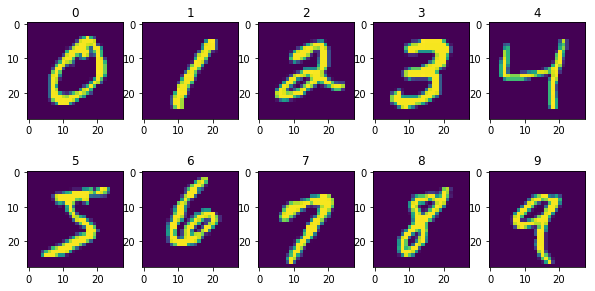

In [24]:
n_classes = 10
inds=np.array([mn_y_train==i for i in range(n_classes)])
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(mn_x_train[np.argmax(inds[i])].reshape(28,28))
    ax[i].set_title(str(i))
plt.show()

### Neural Network Training

Keras is a high level library which can be used to train neural network models. It simplies coding neural networks for the datasets, and as installed, uses tensorflow for the backend. We use Keras for its simplicity and because these models can easily be linked into the cleverhans library to generate adversarial examples. 

We shall start with MNIST as the models and the results are easy to see. The second half of the notebook will repeat the results with CIFAR10. For MNIST, we will use a very simple neural network which takes in the 28 x 28 input, uses a single hidden layer of size 512, and goes uses dense connections to lead to the 10 output classes. This should be familiar and may seem too simple, we will will build up to more complex examples when we get to CIFAR10.

In [25]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

The data must be pre-processed before analysis. We flatten the image and normalize the images so pixel values are between 0 and 1 instead of 0 and 255. The labels must also be inputted as one hot vectors, so we use built in keras functions.

In [26]:
train_images_1d = mn_x_train.reshape((60000, 28 * 28))
train_images_1d = train_images_1d.astype('float32') / 255

test_images_1d = mn_x_test.reshape((10000, 28 * 28))
test_images_1d = test_images_1d.astype('float32') / 255

In [27]:
from keras.utils import to_categorical #this just converts the labels to one-hot class
train_labels = to_categorical(mn_y_train)
test_labels = to_categorical(mn_y_test)

Training the network does not take long and can easily be done quickly on a CPU. Validation accuracy quickly rises to  about 99%.

In [28]:
from keras.callbacks import ModelCheckpoint

h=network.fit(train_images_1d, 
              train_labels, 
              epochs=5, 
              batch_size=128, 
              shuffle=True, 
              callbacks=[ModelCheckpoint('tutorial_MNIST.h5',save_best_only=True)])

Epoch 1/5
60000/60000 [==============================] - 7s 113us/step - loss: 0.2570 - acc: 0.9253
Epoch 2/5
 1280/60000 [..............................] - ETA: 7s - loss: 0.0996 - acc: 0.9711

/Users/pavlos/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:403: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


60000/60000 [==============================] - 6s 106us/step - loss: 0.1034 - acc: 0.9687
Epoch 3/5
60000/60000 [==============================] - 6s 106us/step - loss: 0.0669 - acc: 0.9795
Epoch 4/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.0490 - acc: 0.9855
Epoch 5/5
60000/60000 [==============================] - 7s 109us/step - loss: 0.0377 - acc: 0.9885


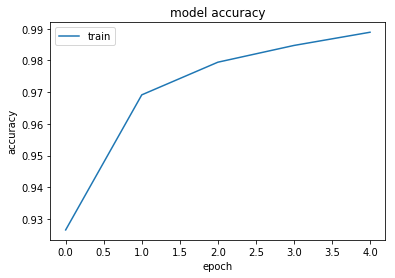

In [9]:
# summarize history for accuracy
plt.plot(h.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [10]:
score, acc = network.evaluate(test_images_1d, 
                            test_labels,
                            batch_size=128)

print ("Test Accuracy: %.5f" % acc)

10000/10000 [==============================] - 0s 42us/step
Test Accuracy: 0.97850


In [11]:
network.save('tutorial_MNIST.h5')

### Cleverhans Integration

Cleverhans is a library written by researchers on adversarial examples, many of whom are with Google Brain. The library has wrappers that allow us to take the Keras model thatwe just made and create adversarial examples.

If the model has already been created and we do not want to recreate it, just run the code below to reload the model.

In [1]:
from keras.models import load_model
network = load_model('tutorial_MNIST.h5')

Using TensorFlow backend.
/Users/pavlos/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#%pip install -e git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

In [3]:
from cleverhans.utils_keras import KerasModelWrapper
wrap = KerasModelWrapper(network)

### FGSM

The **F**ast **G**radient **S**ign **M**ethod is a non-target attack. Using the parameters in the neural network we trained, the FGSM method calculates the $\nabla$ of the cost function for the particular input. By adding this gradient to the image times some parameter $\epsilon$, we know that the cost function will increase. If the gradient is large enough, then the predictor is likely to change.

In [6]:
x = tf.placeholder(tf.float32, shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))

As mentioned above, the $\epsilon \nabla$ is added to the image to create the adversarial example. $\epsilon$ is given by fgsm_rate in the code below. We chose this value since it leads low adversarial accuracy but the images are still easily discernible by eye. Too high of a value would make the images look like random noise, but too low values would leave the adversarial accuracy very high.

In [18]:
from cleverhans.attacks import FastGradientMethod
fgsm = FastGradientMethod(wrap, sess=session)

fgsm_rate = 0.08
fgsm_params = {'eps': fgsm_rate,'clip_min': 0.,'clip_max': 1.}
adv_x = fgsm.generate(x, **fgsm_params)
adv_x = tf.stop_gradient(adv_x)
adv_prob = network(adv_x)

In [19]:
fetches = [adv_prob]
fetches.append(adv_x)
outputs = session.run(fetches=fetches, feed_dict={x:test_images_1d}) 
adv_prob = outputs[0]
adv_examples = outputs[1]

FailedPreconditionError: Attempting to use uninitialized value dense_2_1/bias
	 [[Node: dense_2_1/bias/read = Identity[T=DT_FLOAT, _class=["loc:@dense_2_1/bias"], _device="/job:localhost/replica:0/task:0/cpu:0"](dense_2_1/bias)]]

Caused by op 'dense_2_1/bias/read', defined at:
  File "/Users/pavlos/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/pavlos/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-3c3c7c88c640>", line 6, in <module>
    network.add(layers.Dense(10, activation='softmax'))
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/keras/models.py", line 489, in add
    output_tensor = layer(self.outputs[0])
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 576, in __call__
    self.build(input_shapes[0])
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/keras/layers/core.py", line 836, in build
    constraint=self.bias_constraint)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 400, in add_weight
    constraint=constraint)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 385, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 316, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1338, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/pavlos/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_2_1/bias
	 [[Node: dense_2_1/bias/read = Identity[T=DT_FLOAT, _class=["loc:@dense_2_1/bias"], _device="/job:localhost/replica:0/task:0/cpu:0"](dense_2_1/bias)]]


In [20]:
adv_predicted = adv_prob.argmax(1)
adv_accuracy = np.mean(adv_predicted == mn_y_test)

print("Adversarial accuracy: %.5f" % adv_accuracy)

AttributeError: 'Tensor' object has no attribute 'argmax'

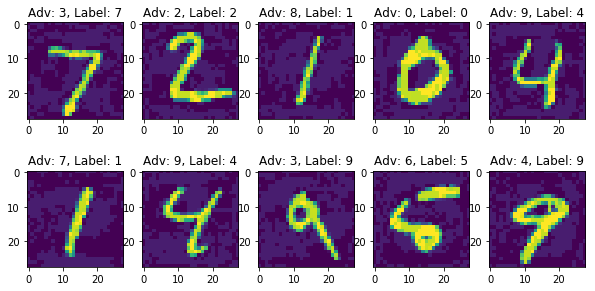

In [18]:
n_classes = 10
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(adv_examples[i].reshape(28,28))
    ax[i].set_title("Adv: %d, Label: %d" % (adv_predicted[i], mn_y_test[i]))
plt.show()

From the examples above, we can see that many of the examples are misclassified from the true labels. Since the changes are non-targetted, the adversarial labels do not seem to show significant trends but are clearly not the numbers in the picture.  

### JSMA

The JSMA method is slightly more complicated than FGSM and full explanations can be found in the following paper: https://arxiv.org/abs/1511.07528. One of the main differences is that this method is that the method generates targeted examples. For example, given a 4, we could perturb the image to register as any digit we desire between 0 and 9.

In [19]:
x = tf.placeholder(tf.float32, shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))

results = np.zeros((10, 10000))
perturbations = np.zeros((10, 10000))
grid_shape = (10, 10, 28, 28, 1)
grid_data = np.zeros(grid_shape)


from cleverhans.attacks import SaliencyMapMethod
jsma = SaliencyMapMethod(wrap, sess=session)

jsma_params = {'theta': 1., 
               'gamma': 0.1,
               'clip_min': 0., 
               'clip_max': 1.,
               'y_target': None}

In [20]:
from cleverhans.utils import other_classes, grid_visual

for index in range(int(len(mn_x_test) / 100)):
    sample = test_images_1d[index: index + 1]
    current = mn_y_test[index]
    target_classes = other_classes(10, current)
    grid_data[current, current, :, :, :] = np.reshape(
            sample, (28, 28, 1))
    
    for target in target_classes:
        one_hot_target = np.zeros((1, 10))
        one_hot_target[0, target] = 1
        jsma_params['y_target'] = one_hot_target
        adv_x = jsma.generate_np(sample, **jsma_params)
        
        grid_data[target, current, :, :, :] = np.reshape(
                adv_x, (28, 28, 1))
        
    if index % 10 == 0:
        print(index)
        print(sample.shape)
        print(one_hot_target)
        print(adv_x.shape)

0
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
10
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
20
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 784)
30
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
40
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
50
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
60
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
70
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
80
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
90
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)


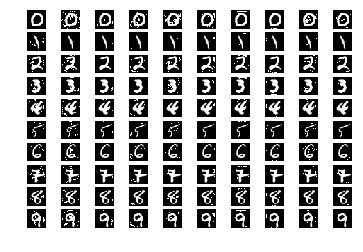

In [22]:
plt.figure(figsize = (20, 20))
_ = grid_visual(grid_data)

Each row in the above plot shows an example for a particular starting class / digit. Using JSMA, we were able to generate examples that adversarially were designed to be  predicted as $0, 1, \dots$ where each column represents the adversarial target class.

## CIFAR10

Below, we repeat the attack mehtods described above for a neural network on CIFAR10. This library is decently larger and requires a more complex CNN to train properly.

In [23]:
import numpy as np
from keras.datasets import mnist
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

session = tf.Session()
keras.backend.set_session(session)

(c10_x_train, c10_y_train), (c10_x_test, c10_y_test) = cifar10.load_data()

As a refresher, CIFAR10 is a dataset for small color images which should be classifying into classes based on the object the image such as an airplane or boat.

Each image is 32 x 32 x 3, for a size of 3072 for each input.

In [24]:
print ("Training Examples: %d" % len(c10_x_train))
print ("Test Examples: %d" % len(c10_x_test))

Training Examples: 50000
Test Examples: 10000


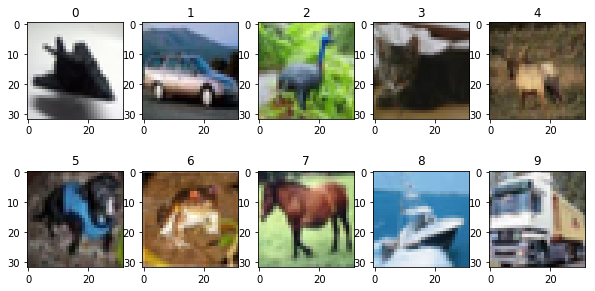

In [25]:
n_classes = 10
inds=np.array([c10_y_train==i for i in range(n_classes)])
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(c10_x_train[np.argmax(inds[i])].reshape(32,32,3))
    ax[i].set_title(str(i))
plt.show()

### Neural Network Training

In [26]:
from keras import models, layers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout

model = models.Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
c10_x_train = c10_x_train.astype('float32') / 255
c10_x_test = c10_x_test.astype('float32') / 255

In [28]:
from keras.utils import to_categorical #this just converts the labels to one-hot class
train_labels = to_categorical(c10_y_train)
test_labels = to_categorical(c10_y_test)

In [29]:
from keras.callbacks import ModelCheckpoint
m = model.fit(c10_x_train, train_labels, validation_data=(c10_x_test, test_labels), epochs=2, batch_size=32)

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 182s 4ms/step - loss: 1.5259 - acc: 0.4518 - val_loss: 1.2332 - val_acc: 0.5631
Epoch 2/2
50000/50000 [==============================] - 189s 4ms/step - loss: 1.2354 - acc: 0.5635 - val_loss: 1.1369 - val_acc: 0.5926


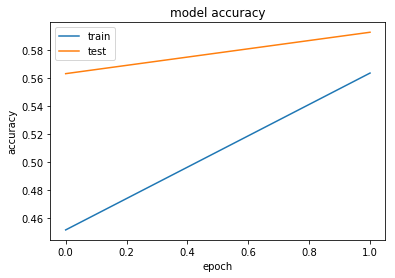

In [30]:
# summarize history for accuracy
plt.plot(m.history['acc'])
plt.plot(m.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
score, acc = model.evaluate(c10_x_test, 
                            test_labels,
                            batch_size=128)

print ("Test Accuracy: %.5f" % acc)

10000/10000 [==============================] - 6s 585us/step
Test Accuracy: 0.59260


In [32]:
model.save('tutorial_CIFAR.h5')

### Cleverhans Integration

Cleverhans is a library written by researchers on adversarial examples, many of whom are with Google Brain. The library has wrappers that allow us to take the Keras model thatwe just made and create adversarial examples.

If the model has already been created and we do not want to recreate it, just run the code below to reload the model.

In [33]:
from keras.models import load_model
model = load_model('tutorial_CIFAR.h5')

In [34]:
from cleverhans.utils_keras import KerasModelWrapper
wrap = KerasModelWrapper(model)

In [35]:
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
y = tf.placeholder(tf.float32, shape=(None, 10))

In [36]:
from cleverhans.attacks import FastGradientMethod
fgsm = FastGradientMethod(wrap, sess=session)

fgsm_rate = 0.03
fgsm_params = {'eps': fgsm_rate,'clip_min': 0.,'clip_max': 1.}
adv_x = fgsm.generate(x, **fgsm_params)
adv_x = tf.stop_gradient(adv_x)
adv_prob = model(adv_x)

In [37]:
fetches = [adv_prob]
fetches.append(adv_x)
outputs = session.run(fetches=fetches, feed_dict={x:c10_x_test}) 
adv_prob = outputs[0]
adv_examples = outputs[1]

In [38]:
adv_predicted = adv_prob.argmax(1)
print(adv_predicted.shape)
adv_accuracy = np.mean(adv_predicted == c10_y_test.reshape(10000,))

print("Adversarial accuracy: %.5f" % adv_accuracy)

(10000,)
Adversarial accuracy: 0.23060


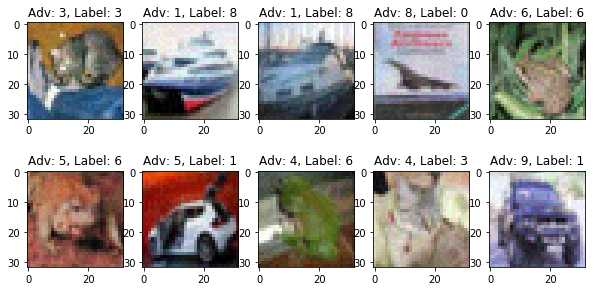

In [39]:
n_classes = 10
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(10):
    ax[i].imshow(adv_examples[i].reshape(32,32,3))
    ax[i].set_title("Adv: %d, Label: %d" % (adv_predicted[i], c10_y_test[i]))
plt.show()

From the examples above, we can see that many of the examples are misclassified from the true labels. Since the changes are non-targetted, the adversarial labels do not seem to show significant trends but are clearly not the numbers in the picture.  

### JSMA

The JSMA method is slightly more complicated than FGSM and full explanations can be found in the following paper: https://arxiv.org/abs/1511.07528. One of the main differences is that this method is that the method generates targeted examples. For example, given a 4, we could perturb the image to register as any digit we desire between 0 and 9.

In [40]:
session.close()
session = tf.Session()
keras.backend.set_session(session)
from keras.models import load_model
model = load_model('tutorial_CIFAR.h5')

In [41]:
from cleverhans.utils_keras import KerasModelWrapper
wrap = KerasModelWrapper(model)

In [61]:
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
y = tf.placeholder(tf.float32, shape=(None, 10))

grid_shape = (10, 10, 32, 32, 3)
grid_data = np.zeros(grid_shape, dtype='f')


from cleverhans.attacks import SaliencyMapMethod

jsma = SaliencyMapMethod(wrap, back='tf', sess=session)

jsma_params = {'theta': 1., 
               'gamma': 0.1,
               'clip_min': 0., 
               'clip_max': 1.,
               'y_target': None}

In [83]:
from cleverhans.utils import other_classes

sample = c10_x_train[0:0+1]
current = c10_y_test[1][0]
target_classes = other_classes(10, current)
grid_data[current, current, :, :, :] = np.reshape(
            sample, (32, 32, 3))

target = 5 # target_classes[0]
one_hot_target = np.zeros((1, 10))
one_hot_target[0, target] = 1
jsma_params['y_target'] = one_hot_target

print(jsma_params)
adv_x = jsma.generate_np(sample, **jsma_params)

{'theta': 1.0, 'gamma': 0.1, 'clip_min': 0.0, 'clip_max': 1.0, 'y_target': array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])}


InvalidArgumentError: Retval[0] does not have value

In [70]:
from cleverhans.utils import other_classes, grid_visual

for index in range(5):
    sample = c10_x_train[index:index+1]
    current = c10_y_test[index][0]
    target_classes = other_classes(10, current)
    grid_data[current, current, :, :, :] = np.reshape(
            sample, (32, 32, 3))
    
    for target in target_classes:
        one_hot_target = np.zeros((1, 10))
        one_hot_target[0, target] = 1
        jsma_params['y_target'] = one_hot_target
        adv_x = jsma.generate_np(sample, **jsma_params)
    
    if index % 10 == 0:
        print(index)

InvalidArgumentError: Retval[0] does not have value

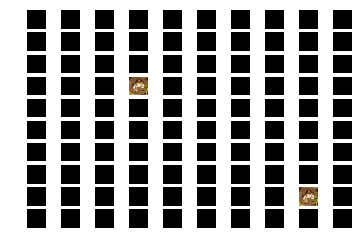

In [71]:
plt.figure(figsize = (20, 20))
_ = grid_visual(grid_data)